# Plot the correlation length

In [1]:
using Pkg
Pkg.activate("../")
Pkg.resolve()
Pkg.instantiate()

  Activating project at `~/Projects/EMODnet/EMODnet-Chemistry-GriddedMaps`
No packages added to or removed from `~/Projects/EMODnet/EMODnet-Chemistry-GriddedMaps/Project.toml`
No packages added to or removed from `~/Projects/EMODnet/EMODnet-Chemistry-GriddedMaps/Manifest.toml`
Precompiling packages...
   1765.4 ms  ✓ Fontconfig_jll
    810.3 ms  ✓ Cairo_jll
   3157.3 ms  ✓ Interpolations → InterpolationsUnitfulExt
   3192.7 ms  ✓ KernelDensity
    869.2 ms  ✓ HarfBuzz_jll
    684.6 ms  ✓ libass_jll
    818.4 ms  ✓ Pango_jll
   1173.3 ms  ✓ FFMPEG_jll
   1063.9 ms  ✓ Cairo
  11181.0 ms  ✓ PlotUtils
  11660.3 ms  ✓ GeometryBasics → GeometryBasicsGeoInterfaceExt
  11690.7 ms  ✓ Packing
  12179.7 ms  ✓ ShaderAbstractions
  15645.4 ms  ✓ GridLayoutBase
  25689.7 ms  ✓ MathTeXEngine
  29400.9 ms  ✓ TiffImages
 123830.8 ms  ✓ Makie
   5548.4 ms  ✓ GeoInterface → GeoInterfaceMakieExt
   5607.7 ms  ✓ GeoJSON → GeoJSONMakieExt
  10992.7 ms  ✓ Shapefile → ShapefileMakieExt
   8484.1 ms  ✓ GeoMaki

In [7]:
Pkg.add("OrderedCollections")

   Resolving package versions...
    Updating `~/Projects/EMODnet/EMODnet-Chemistry-GriddedMaps/Project.toml`
  [bac558e1] + OrderedCollections v1.8.1
No packages added to or removed from `~/Projects/EMODnet/EMODnet-Chemistry-GriddedMaps/Manifest.toml`


In [9]:
using DIVAnd
using ColorSchemes
using NCDatasets
using GeoDatasets
using CairoMakie, GeoMakie
using GeometryOps, GeoInterface
using JupyterFormatter
enable_autoformat()
include("./config.jl")

plot_field_var_fast (generic function with 3 methods)

## Load bathymetry 

In [10]:
topodir = "/home/ctroupin/data/GEBCO/"
topofile = joinpath(topodir, "gebco_30sec_16.nc")
bx, by, b = DIVAnd.extract_bath(topofile, true, lonr, latr)
b[b.<0.0] .= NaN;

lon_landsea, lat_landsea, landsea = GeoDatasets.landseamask(; resolution = 'i', grid = 5)
landsea[landsea.==2] .= 1;

### Create and edit mask

In [11]:
xi, yi, mask = load_mask(topofile, true, lonr, latr, 0.0);
coordinatelist = read_polygon_json("./mask.json");
edit_mask!(xi, yi, mask, coordinatelist)

### Read horizontal correlation length

In [15]:
CLfile = "/home/ctroupin/data/EMODnet-Chemistry/correlation_len_0.25.nc"
# CLfile = "/home/ctroupin/data/EMODnet/EMODnet-Chemistry/2024/netCDF/correlation_len_varlen1_0.25.nc"
isfile(CLfile)
ds = NCDataset(CLfile, "r")
CL = ds["correlation_length"][:, :]
close(ds)
CL[mask.==0] .= NaN;

### Vertical correlation length

In [16]:
lenz = min.(max.(25.0, depthr ./ 10), 500.0);

## Make the plot

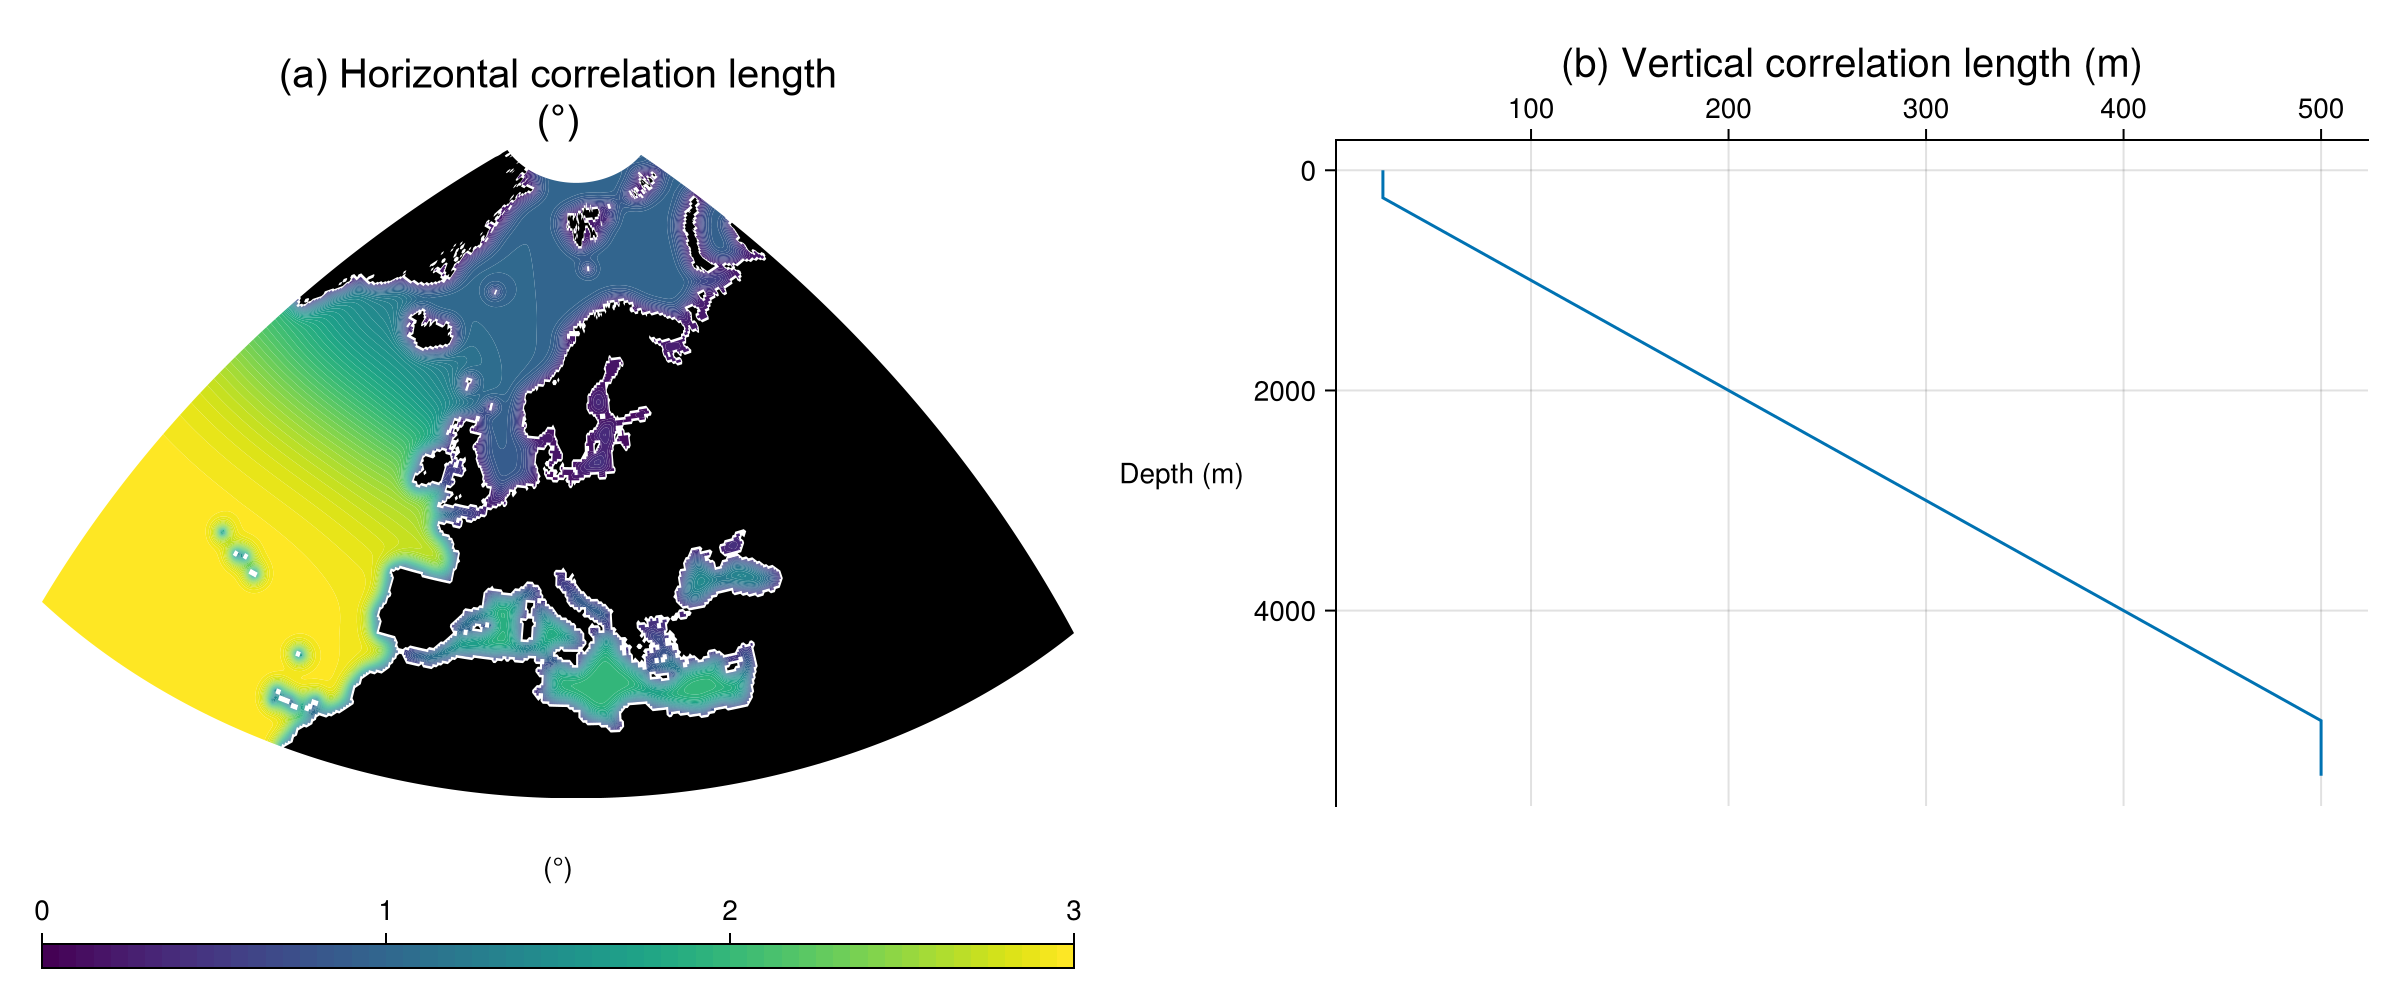

CairoMakie.Screen{IMAGE}


In [40]:
fig = Figure(size = (1200, 500))
ga = GeoAxis(
    fig[1, 1],
    title = "(a) Horizontal correlation length\n(°)",
    titlefont = "Arial",
    titlesize = 20,
    dest = "+proj=laea +lon_0=15 +lat_0=45",
    xticks = [],
    yticks = [],
)

hm = contourf!(ga, lonr, latr, CL, levels = collect(0:0.05:3.0))
Colorbar(fig[2, 1], hm, label = "(°)", labelrotation = 0, vertical = false)

masklayer = contourf!(ga, xi, yi, mask, levels = [0.0, 0.0001], colormap = Reverse(:binary))

xlims!(ga, lonr[1], lonr[end])
ylims!(ga, latr[1], latr[end])
# hidedecorations!(ga)

ax2 = Axis(
    fig[1, 2],
    xaxisposition = :top,
    xlabel = "(b) Vertical correlation length (m)",
    xlabelsize = 20,
    ylabel = "Depth (m)",
    ylabelrotation = 0,
    yreversed = true,
)
lines!(ax2, lenz, depthr)
hidespines!(ax2, :b, :r)
save(joinpath(figdir, "correlation_length.png"), fig)
display(fig)

In [34]:
(CL)

NaN